In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import statsmodels.api as sm
import xlrd

# Read in data

In [2]:
# COVID-19 cases
df_case = pd.read_csv("../02_Data//01_COVID/covid_us_county.csv")
df_case.dropna(inplace=True)

# Socio-Demographics
df_sd = pd.read_csv("../02_Data//02_SociaDemographics/us_final.csv",index_col=0)
df_sd = df_sd.reset_index()

# Policy
df_policy = pd.read_excel(r"../02_Data\03_Policy\COVID_StatePolicy_final.xlsx")
df_policy.head()

# Mobility
df_mobility = pd.read_csv("../02_Data//05_Mobility/2020_US_Region_Mobility_Report.csv")

## Preprocess and clean data

In [3]:
# COVID-19 cases
mData1 = []
df_case['fips'] = df_case.fips.astype(int)
df_sir = df_case.copy()
fips = list(set(df_sir['fips']))
for fip in tqdm(fips):
    df = df_sir[(df_sir['fips']==fip)]
    
    df = df[df['cases']>=5]
    df = df.reset_index(drop=True)
    df = df.reset_index()

    df = df.to_dict("records")
    # 7 day Moving average
    for i in range(len(df)-6):
        mdf = df[i:i+7]
        mdf_case = [m['cases'] for m in mdf]
        mdf_death = [m['deaths'] for m in mdf]
        df[i+3]['cases_7'] = np.sum(mdf_case)/7
        df[i+3]['deaths_7'] = np.sum(mdf_death)/7
        df[i+3]['day_index'] = df[i+3]['index']
        mData1.append(df[i+3])
    
# The log value
for i in range(len(mData1)-1):
    mData1[i+1]['delta_case'] = np.log(mData1[i+1]['cases_7']) - np.log(mData1[i]['cases_7'])
    pass
del mData1[0]

df_case_delta = pd.DataFrame(mData1)

100%|█████████████████████████████████████████████████████████████████████████████| 3241/3241 [00:29<00:00, 110.61it/s]


In [4]:
# Mobility

df_mobility_processed = df_mobility.drop(labels=['census_fips_code','metro_area','country_region_code', 'country_region'], axis=1)

# there are 6 different place categories provided by google mobility, so let's store them in a simple list.
mobility_predictors = df_mobility_processed.columns[4:].tolist()
mobility_fontsize = 30

# check how many rows have values for all 6 predictors
df_mobility_processed_2 = df_mobility_processed.loc[df_mobility_processed[mobility_predictors[0]].notnull() & df_mobility_processed[mobility_predictors[1]].notnull() & df_mobility_processed[mobility_predictors[2]].notnull() &
       df_mobility_processed[mobility_predictors[3]].notnull() & df_mobility_processed[mobility_predictors[4]].notnull() & df_mobility_processed[mobility_predictors[5]].notnull()]
df_mobility_processed_2 = df_mobility_processed_2.loc[df_mobility_processed['sub_region_1'].isnull()]

In [5]:
# Policy

df_policy_merge=df_case.merge(df_policy, on=['state_code','state'],how='left')
df_policy_merge['date'] = pd.to_datetime(df_policy_merge['date'])

# get daily data from cumulative sum
df_policy_merge['new_cases']=df_policy_merge['cases'].groupby(df_policy_merge['fips']).diff().fillna(0)
df_policy_merge['new_deaths']=df_policy_merge['deaths'].groupby(df_policy_merge['fips']).diff().fillna(0)

# impute 0 for dates with negative case inceases
df_policy_merge['new_cases']=df_policy_merge['new_cases'].clip(lower=0)
df_policy_merge['new_deaths']=df_policy_merge['new_deaths'].clip(lower=0)

# Calculate 7-day moving average

df_policy_merge['cases_7day_ave'] = df_policy_merge.groupby('fips', as_index=False)['new_cases'].rolling(window=7,center=True).mean().fillna(0).reset_index(
    0, drop=True)

df_policy_merge['policy_home']=np.where((df_policy_merge['date'].astype('datetime64[ns]')>=df_policy_merge['stay_at_home'].astype('datetime64[ns]')) 
                                 & (df_policy_merge['date'].astype('datetime64[ns]')<=df_policy_merge['end_stay_at_home'].astype('datetime64[ns]')), 1, 0)

df_policy_merge['policy_school']=np.where((df_policy_merge['date'].astype('datetime64[ns]')>=df_policy_merge['close_school'].astype('datetime64[ns]')), 1, 0)

df_policy_merge['policy_business']=np.where((df_policy_merge['date'].astype('datetime64[ns]')>=df_policy_merge['close_nonessential_business'].astype('datetime64[ns]')) 
                                 & (df_policy_merge['date'].astype('datetime64[ns]')<=df_policy_merge['reopen_business'].astype('datetime64[ns]')), 1, 0)

df_policy_merge['policy_restaurant']=np.where((df_policy_merge['date'].astype('datetime64[ns]')>=df_policy_merge['close_restaurant'].astype('datetime64[ns]')) 
                                 & (df_policy_merge['date'].astype('datetime64[ns]')<=df_policy_merge['reopen_restaurant'].astype('datetime64[ns]')), 1, 0)

df_policy_merge['policy_facemask']=np.where((df_policy_merge['date'].astype('datetime64[ns]')>=df_policy_merge['facemask'].astype('datetime64[ns]')), 1, 0)

df_policy_merge['policy_gym']=np.where((df_policy_merge['date'].astype('datetime64[ns]')>=df_policy_merge['close_gym'].astype('datetime64[ns]')) 
                                 & (df_policy_merge['date'].astype('datetime64[ns]')<=df_policy_merge['reopen_gym'].astype('datetime64[ns]')), 1, 0)

df_policy_merge['policy_theater']=np.where((df_policy_merge['date'].astype('datetime64[ns]')>=df_policy_merge['close_theater'].astype('datetime64[ns]')) 
                                 & (df_policy_merge['date'].astype('datetime64[ns]')<=df_policy_merge['reopen_theater'].astype('datetime64[ns]')), 1, 0)

df_policy_merge['policy_bar']=np.where((df_policy_merge['date'].astype('datetime64[ns]')>=df_policy_merge['close_bar'].astype('datetime64[ns]')) 
                                 & (df_policy_merge['date'].astype('datetime64[ns]')<=df_policy_merge['reopen_bar'].astype('datetime64[ns]')), 1, 0)


In [6]:
# Socio Demographics

df_sd.loc[549,'ChildPoverty'] = df_sd[df_sd["state"]=="Hawaii"]["ChildPoverty"].median()

df_missing_crime = df_sd[df_sd["crime_rate_per_100000"].isnull()]
df_missing_crime_num = df_missing_crime.groupby("state")["state"].count()

crime_columns = ["crime_rate_per_100000","IDNO","Crime_CPOPARST","Crime_CPOPCRIM","Crime_AG_OFF","Crime_COVIND","Crime_MODINDX","Crime_MURDER","Crime_RAPE","Crime_ROBBERY","Crime_AGASSLT","Crime_BURGLRY","Crime_LARCENY","Crime_MVTHEFT","Crime_ARSON"]
state_list = ["Alaska","New Mexico","South Dakota"]
for state in state_list:
    index_list = df_missing_crime[df_missing_crime['state']==state]["index"].tolist()
    for crime in crime_columns:
        for index in index_list:
            df_sd.loc[index-1,crime] = df_sd[df_sd['state']==state][crime].median()
            pass
        pass
    pass



# EDA Figures

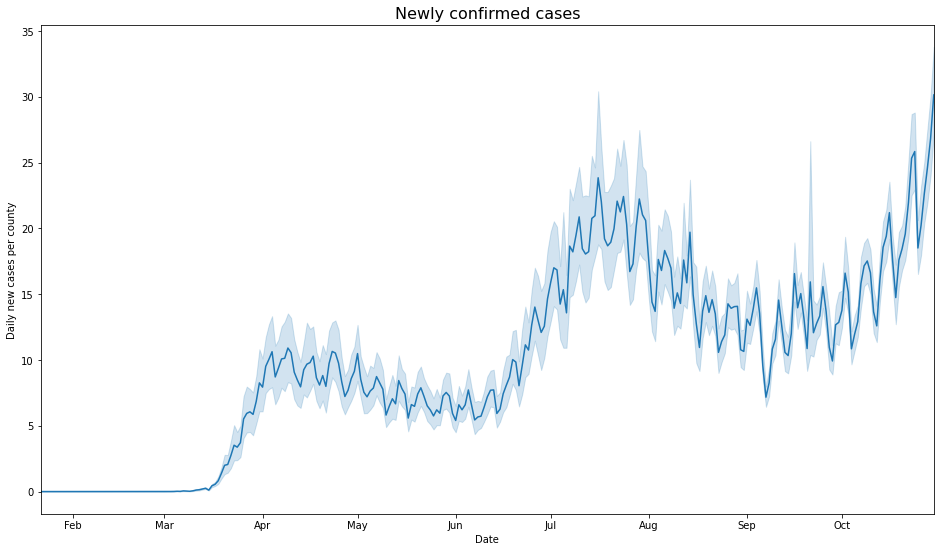

In [7]:
# new cases
plt.figure(figsize=(16,9))
g=sns.lineplot(x="date", y="new_cases",
             data=df_policy_merge)
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator,formats=["","%b", '%d', '%H:%M', '%H:%M', '%S.%f'],show_offset=False)
g.xaxis.set_major_locator(locator)
g.xaxis.set_major_formatter(formatter)
g.set_xlim(df_policy_merge['date'].min(),df_policy_merge['date'].max())
g.set_xlabel('Date')
g.set_ylabel('Daily new cases per county')
plt.title("Newly confirmed cases",fontsize=16)
plt.show()

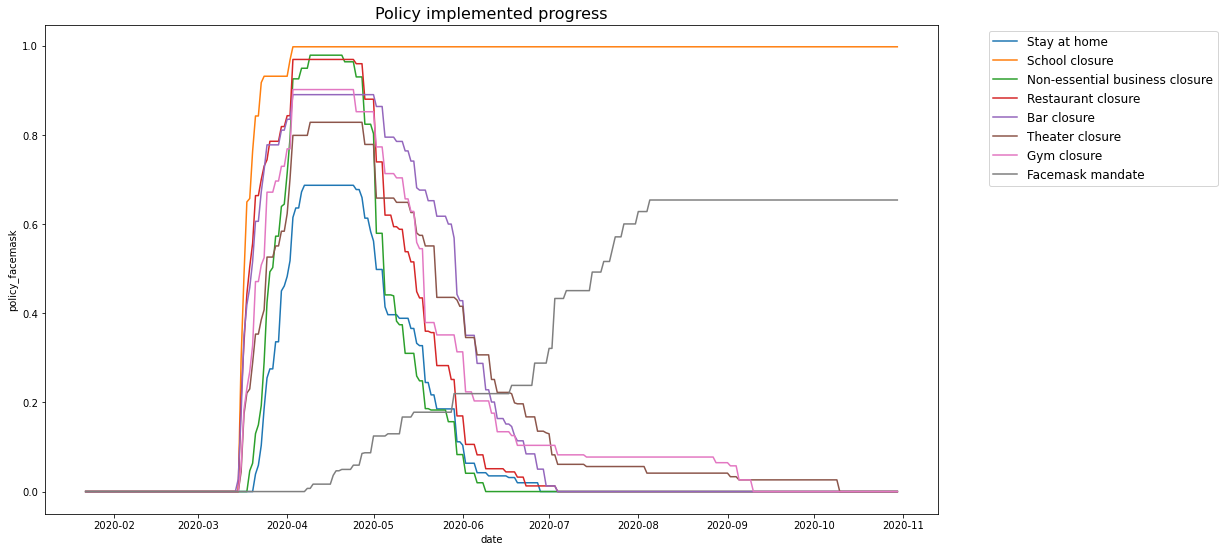

In [8]:
plt.figure(figsize=(16,9))
sns.lineplot(x="date", y="policy_home",ci=None,label="Stay at home",
             data=df_policy_merge)
sns.lineplot(x="date", y="policy_school",ci=None,label="School closure",
             data=df_policy_merge)
sns.lineplot(x="date", y="policy_business",ci=None,label="Non-essential business closure",
             data=df_policy_merge)
sns.lineplot(x="date", y="policy_restaurant",ci=None,label="Restaurant closure",
             data=df_policy_merge)
sns.lineplot(x="date", y="policy_bar",ci=None,label="Bar closure",
             data=df_policy_merge)
sns.lineplot(x="date", y="policy_theater",ci=None,label="Theater closure",
             data=df_policy_merge)
sns.lineplot(x="date", y="policy_gym",ci=None,label="Gym closure",
             data=df_policy_merge)
sns.lineplot(x="date", y="policy_facemask",ci=None,label="Facemask mandate",
             data=df_policy_merge)

# g.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
# g.xaxis.set_major_locator(mdates.DayLocator(interval=30))
g.set_xlabel('Date')
g.set_ylabel('Proportion of counties under each policy')
plt.legend(fontsize='large',bbox_to_anchor=(1.05, 1),loc='upper left')
plt.title("Policy implemented progress",fontsize=16)
plt.show()

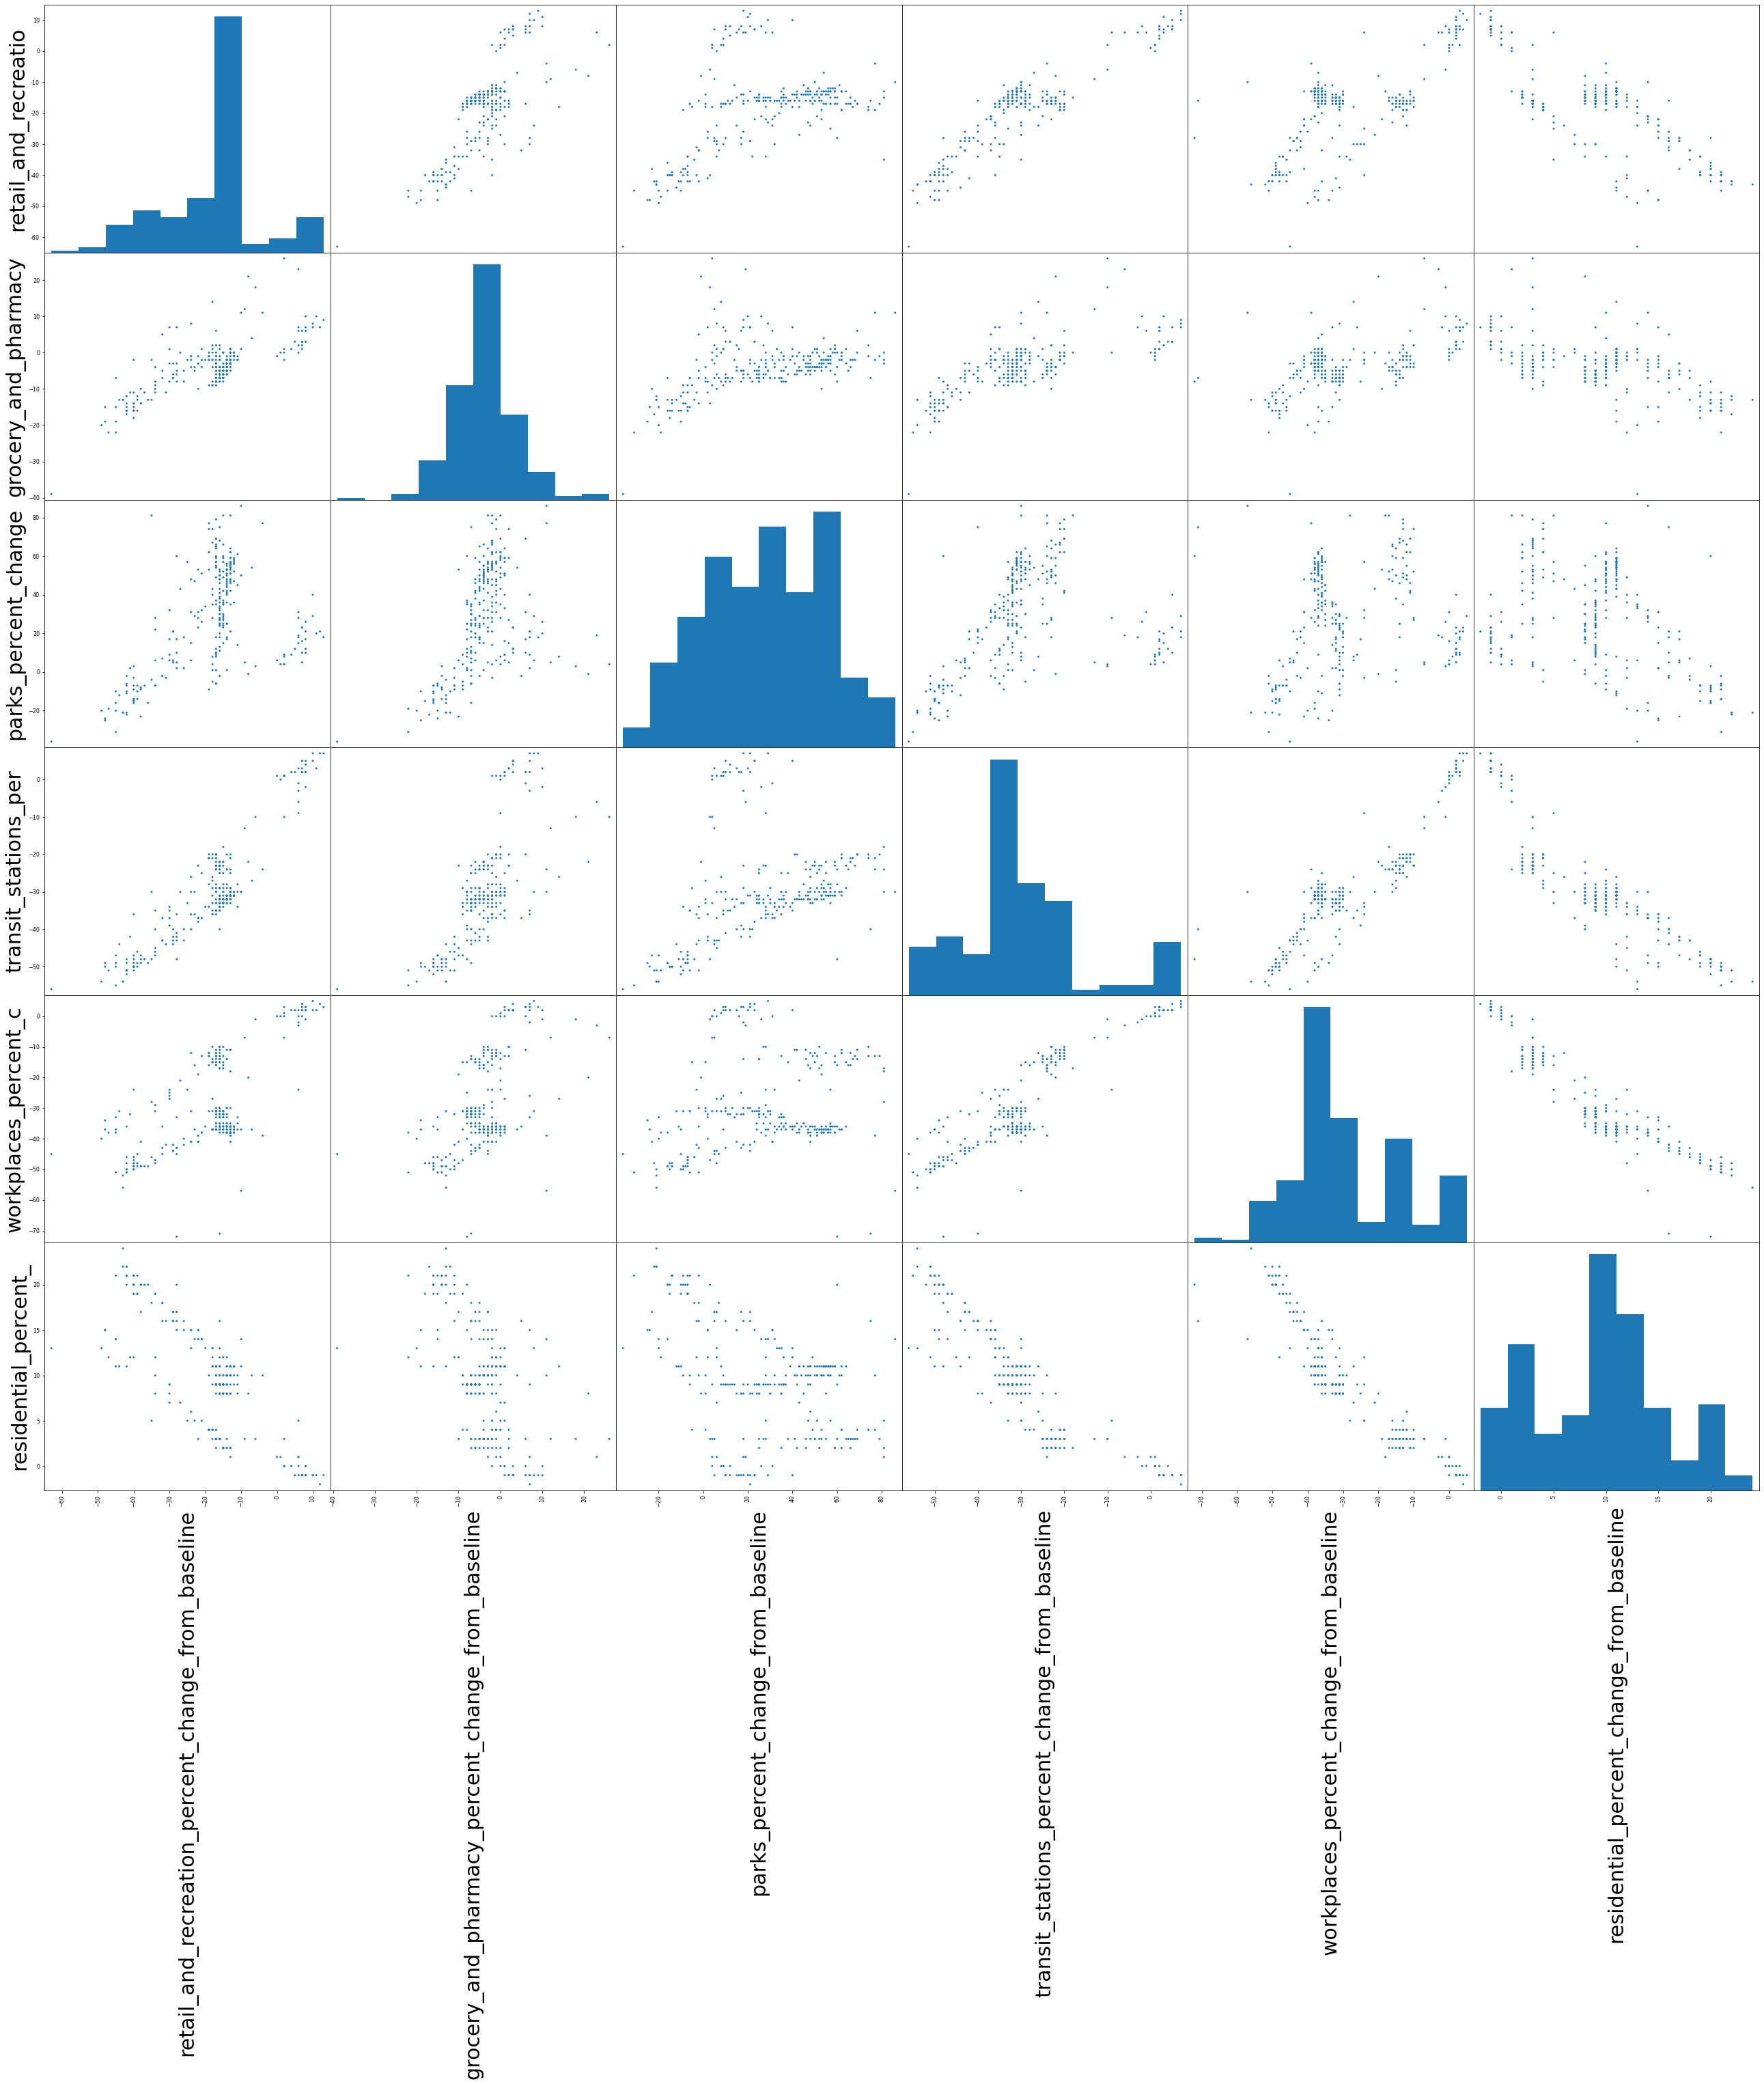

In [9]:
scatter = pd.plotting.scatter_matrix(df_mobility_processed.loc[df_mobility_processed['sub_region_1'].isnull()], alpha=1, figsize=(45, 40))
for ax in scatter.ravel():
    ax.set_xlabel(ax.get_xlabel(), rotation=90, fontsize=mobility_fontsize)
    ax.set_ylabel(ax.get_ylabel()[0:20], fontsize=mobility_fontsize)

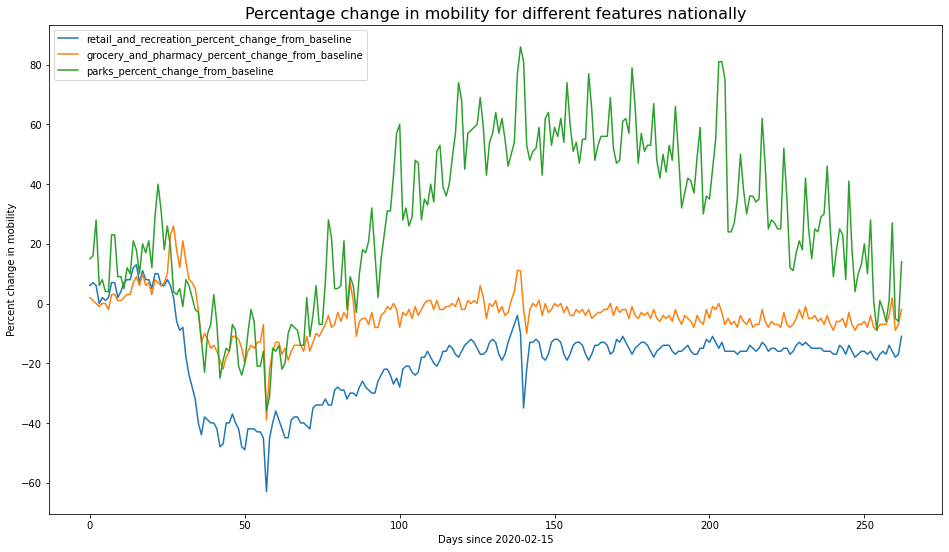

In [10]:
plt.figure(figsize=(16,9))
for predictor in mobility_predictors[0:3]:
    plt.plot(df_mobility_processed_2[predictor], label=f"{predictor}")
    plt.title("Percentage change in mobility for different features nationally",fontsize=16)
    plt.xlabel(f"Days since {df_mobility_processed_2['date'][0]}")
    plt.ylabel("Percent change in mobility")
    
plt.legend()

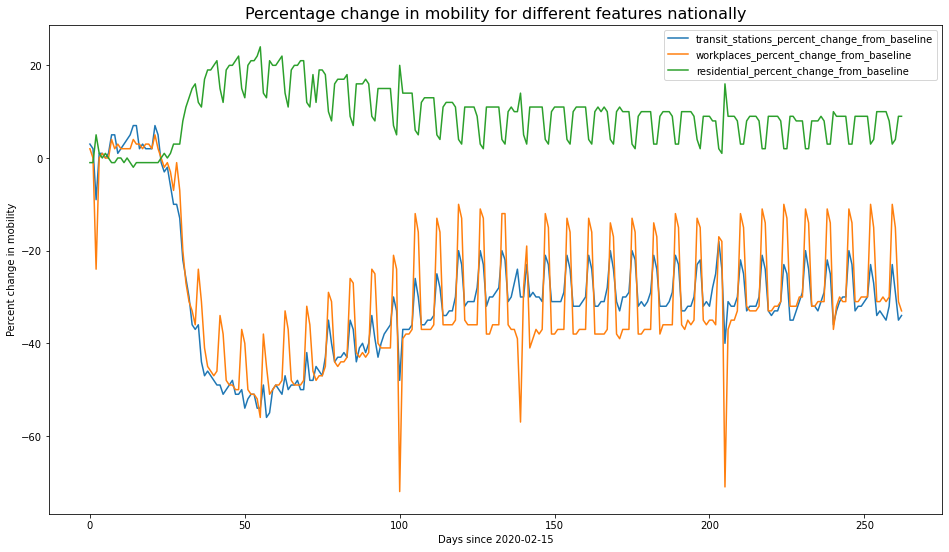

In [11]:
plt.figure(figsize=(16,9))
for predictor in mobility_predictors[3:]:
    plt.plot(df_mobility_processed_2[predictor], label=f"{predictor}")
    plt.title("Percentage change in mobility for different features nationally",fontsize=16)
    plt.xlabel(f"Days since {df_mobility_processed_2['date'][0]}")
    plt.ylabel("Percent change in mobility")
    
plt.legend()

<AxesSubplot:>

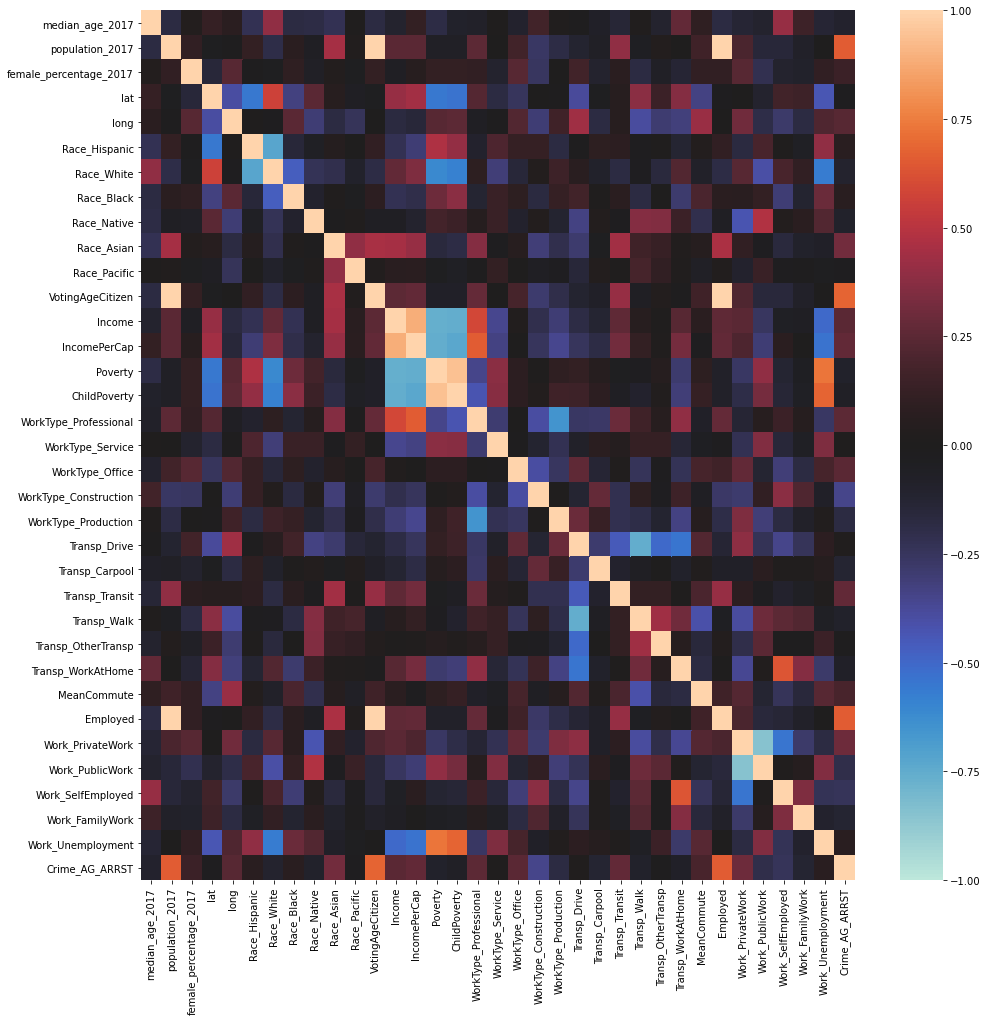

In [12]:
cor = df_sd.drop(columns=["index","fips","IncomeErr","IncomePerCapErr"]+crime_columns).corr()
plt.figure(figsize=(16,16))
sns.heatmap(cor,vmin=-1,vmax=1,center=0)

In [13]:
df_case_delta = df_case_delta[(df_case_delta['cases_7']>=10)&(df_case_delta['date']>="2020-03-01")&(df_case_delta['date']<"2020-05-01")&(df_case_delta['delta_case']>0)]
df_case_delta.dropna(inplace=True)

# Putting all observations in regression
df_case_demo = pd.merge(df_case_delta[['fips','delta_case','date','day_index']],df_sd.drop(columns=["index","Race_White","WorkType_Office","Transp_Drive","Work_PrivateWork","IncomeErr","IncomePerCapErr","county","state","state_code","Crime_AG_ARRST"]+crime_columns),left_on="fips",right_on="fips")


# Averaging the growth rate
X = df_case_demo.drop(columns=["delta_case"])
y = df_case_demo['delta_case']

X['median_age_2017'] = X['median_age_2017']/100
X['l_population_2017'] = np.log(X['population_2017'])
X['female_percentage_2017'] = X['female_percentage_2017'] / 100
X['Race_Hispanic'] = X['Race_Hispanic'] / 100
X['Race_Black'] = X['Race_Black'] / 100
X['Race_Native'] = X['Race_Native'] / 100
X['Race_Asian'] = X['Race_Asian'] / 100
X['Race_Pacific'] = X['Race_Pacific'] / 100
X['l_income'] = np.log(X['Income'])
X['WorkType_Professional'] = X['WorkType_Professional'] / 100
X['WorkType_Construction'] = X['WorkType_Construction'] / 100
X['WorkType_Service'] = X['WorkType_Service'] / 100
X['WorkType_Production'] = X['WorkType_Production'] / 100

columns = list(X.columns)
del columns[columns.index('fips')]
del columns[columns.index('date')]
for index1,f1 in enumerate(columns):
    for index2, f2 in enumerate(columns[index1:]):
        X[f1 + "_" + f2] = X[f1] * X[f2]       
        pass
    pass


In [14]:
X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=5)
X_train,X_valid,y_train,y_valid = train_test_split(X_train,y_train,test_size=0.375,random_state = 10)

X_train_info = X_train[['fips','date']]
X_test_info = X_test[['fips','date']]
X_valid_info = X_valid[['fips','date']]
X_train = X_train.drop(columns=['fips','date'])
X_test = X_test.drop(columns=['fips','date'])
X_valid = X_valid.drop(columns=['fips','date'])

In [15]:
depth = [10,20,30,40,50]
train_mse_322 = []
valid_mse_322 = []
train_r2_322 = []
valid_r2_322 = []
for d in tqdm(depth):
    
    model_lr = DecisionTreeRegressor(max_depth=d)
    model_lr.fit(X_train,y_train)

    train_pred = model_lr.predict(X_train)
    valid_pred = model_lr.predict(X_valid)

    mse_score_lr_train = mean_squared_error(model_lr.predict(X_train), y_train)
    mse_score_lr_valid = mean_squared_error(model_lr.predict(X_valid), y_valid)
    r2_score_lr_train = r2_score(train_pred,y_train)
    r2_score_lr_valid = r2_score(valid_pred,y_valid)
    train_mse_322.append(mse_score_lr_train)
    valid_mse_322.append(mse_score_lr_valid)
    
    train_r2_322.append(r2_score_lr_train)
    valid_r2_322.append(r2_score_lr_valid)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.31s/it]


The best train score is 1.0
The best valid score is 0.6917481375465308


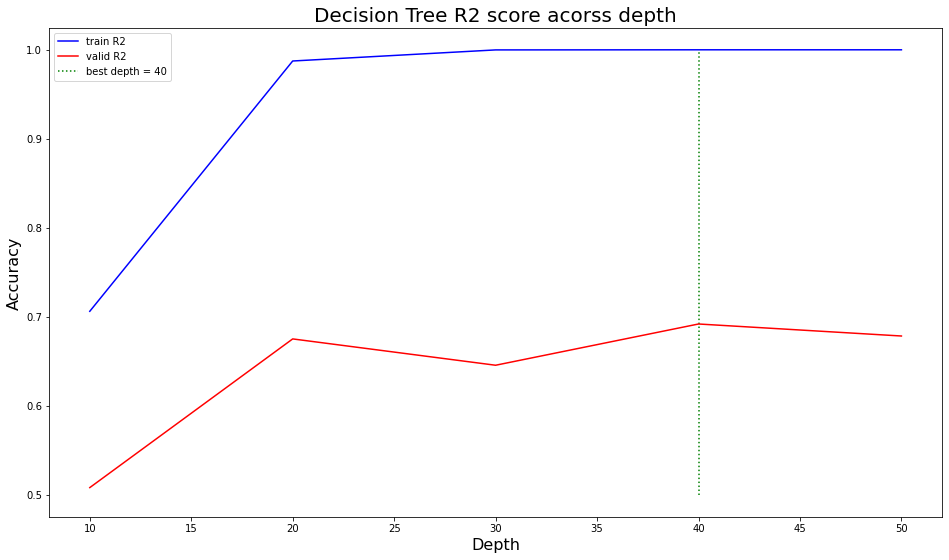

In [16]:
best_depth_index = np.argmax(valid_r2_322)
plt.figure(figsize=(16,9))
plt.plot(depth,train_r2_322,"b",label="train R2")
plt.plot(depth,valid_r2_322,"r",label="valid R2")
plt.vlines(depth[best_depth_index],0.5, 1, linestyles ="dotted", colors ="g",label=f"best depth = {depth[best_depth_index]}")
plt.xlabel("Depth", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.legend()
plt.title("Decision Tree R2 score acorss depth",fontsize=20)

print(f"The best train score is {train_r2_322[best_depth_index]}")
print(f"The best valid score is {valid_r2_322[best_depth_index]}")